In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import scipy.spatial.distance as distance
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

In [2]:
def hypercube_kernel(h, x, x_i):

    """
    h: window width
    x: point x for density estimation
    x_i: point from training data set
    """
    return (x -x_i) / h

def parzen_window(x, h=1):  
   
    if (np.max(x) > h/2):
        return 0
    return 1 

def guassian_window(x, h=1):

    return np.sqrt(2*np.pi*h**2)**(-1) * np.exp(-(np.sum(x**2))/2)

def parzen_estimation(x_samples, point_x, d, h, window_func, kernel_func):
    k_n = 0 
    #print(x_samples.shape)
    for row in x_samples:
        x_i = kernel_func(h, point_x[:,np.newaxis], row[:,np.newaxis])
        k_n += window_func(x_i, h)
    #print(h)
    #print("**")       
    return k_n / (x_samples.shape[0] * h ** d)

def distribution_estimation_parzen(all_data, test_data, h, class_number, parzen_window, hypercube_kernel):
    n = test_data.shape[0]
    d = test_data.shape[1]
    count = -1
    all_estimations = np.zeros((n, class_number))
    for test in test_data:
        count += 1
        estimations = []
        for i in range(class_number):
            class_data = all_data[i]
            estimations.append(parzen_estimation(class_data[0], test, d, h, parzen_window, hypercube_kernel))
        all_estimations[count,:] = estimations
    return all_estimations

In [3]:
class BayesClassifier(object):
    def __init__(self, PDs, Priors = None, Risk = None):
        '''
        PDs: array of PD object
        Priors: arrays of prior probabilities
        Risk: Risk matrix
        NOTE: all PDs should have the same input dim and Risk mat shape should be (dim, dim)
        '''
        self.PDs = PDs
        self.Priors = Priors
        self.Risk = Risk
        self.C = len(PDs) # number of classes

        if self.Risk is None:
            self.init_Risk()
        if self.Priors is None:
            self.init_Prios()
    
    def init_Risk(self):
        self.Risk = np.ones((self.C, self.C)) - np.eye(self.C)

    def init_Prios(self):
        self.Priors = np.array([1 for i in range(self.C)])

    def classify(self, x):
        prs = np.array([PD for PD in self.PDs]).T * self.Priors
        discs = np.dot(prs, self.Risk)
        return np.argmin(discs, axis = 1)
    

In [11]:
test_data = np.loadtxt("testData.csv", delimiter=',', unpack=True)
test_labels = np.loadtxt("testLabels.csv", delimiter=',', unpack=True)
train_data = np.loadtxt("trainData.csv", delimiter=',', unpack=True)
train_labels = np.loadtxt("trainLabels.csv", delimiter=',', unpack=True)

test_data = test_data.T
train_data = train_data.T

In [12]:
# Feature Selection
tr_samples_size, _ = train_data.shape
all_data = np.vstack((train_data,test_data))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
train_data = all_data[:tr_samples_size]
test_data = all_data[tr_samples_size:]

In [16]:
all_data = []
for i in range(class_number):
    cl = train_data[np.where(train_labels == i), :]
    all_data.append(cl)

In [17]:
class_number = 10
print("parzen classifie: hypercube kernel")
parzen_rate = np.zeros(4)
count = 0
for i in [0.25, 1, 2, 9]:
    all_estimations = distribution_estimation_parzen(all_data, test_data, i, class_number,parzen_window, hypercube_kernel)       
    class_density_estimation = all_estimations.T  
    classifier = BayesClassifier(class_density_estimation)
    t_labels = classifier.classify(test_data)
    cnf_matrix = confusion_matrix(test_labels, t_labels)
    parzen_rate[count] = np.sum(np.diag(cnf_matrix))/test_labels.shape
    print("h :", i)
    print("correct confusion rate : ", parzen_rate[count])
    print("probability of classification error : ", 1-parzen_rate[count])
    print("*****")
    count += 1

parzen classifie: hypercube kernel
h : 0.25
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****
h : 1
correct confusion rate :  0.6772
probability of classification error :  0.3228
*****
h : 2
correct confusion rate :  0.0876
probability of classification error :  0.9124
*****
h : 9
correct confusion rate :  0.0876
probability of classification error :  0.9124
*****


In [18]:
print("parzen classifie: Gaussian kernel")    
guassian_rate = np.zeros(4)
count = 0
for i in [0.25, 1, 2, 9]:
    all_estimations = distribution_estimation_parzen(all_data, test_data, i, class_number, guassian_window, hypercube_kernel)       
    class_density_estimation = all_estimations.T  
    classifier = BayesClassifier(class_density_estimation)
    t_labels = classifier.classify(test_data)
    cnf_matrix = confusion_matrix(test_labels, t_labels)
    guassian_rate[count] = np.sum(np.diag(cnf_matrix))/test_labels.shape
    print("h :", i)
    print("correct confusion rate : ", parzen_rate[count])
    print("probability of classification error : ", 1-parzen_rate[count])
    print("*****")
    count += 1  

parzen classifie: Gaussian kernel
h : 0.25
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****
h : 1
correct confusion rate :  0.6772
probability of classification error :  0.3228
*****
h : 2
correct confusion rate :  0.0876
probability of classification error :  0.9124
*****
h : 9
correct confusion rate :  0.0876
probability of classification error :  0.9124
*****


In [19]:
def predict_knn(x, data, labels, K, class_number):
    num_samples = data.shape[0]
    distances = np.array([distance.euclidean(x ,data[i,:]) for i in range(num_samples)])
    index = [i[0] for i in sorted(enumerate(distances), key = lambda x:x[1])[:K]]
    labl = labels[index]
    labl = labl[:,np.newaxis]
    predicts = np.zeros((1,class_number))
    
    for i in range(class_number):
        predicts[:,int(i)] = np.array(np.where(labl == i))[0].shape[0]
    return predicts 

def distribution_estimation(test_data, t_data, train_label, K, class_number):
    dist = np.zeros((test_data.shape[0],class_number))
    count = 0
    for sample in test_data:
        dist[count,:] = predict_knn(sample, t_data, train_label, K, class_number)
        count += 1
    return dist/K

In [20]:
print("knn classifier")
k_nearest_rate = np.zeros(3)
count = 0
for k in [1, 5, 10]:
    class_density_estimation = distribution_estimation(test_data, train_data, train_labels, k, class_number)
    class_density_estimation = class_density_estimation.T 
    classifier = BayesClassifier(class_density_estimation)
    t_labels = classifier.classify(test_data) 
    cnf_matrix = confusion_matrix(test_labels, t_labels)
    k_nearest_rate[count] = np.sum(np.diag(cnf_matrix))/test_labels.shape
    print("k :", k)
    print("correct confusion rate : ", k_nearest_rate[count])
    print("probability of classification error : ", 1-k_nearest_rate[count])
    print("*****")
    count += 1 

knn classifier
k : 1
correct confusion rate :  0.9248
probability of classification error :  0.07520000000000004
*****
k : 5
correct confusion rate :  0.9056
probability of classification error :  0.09440000000000004
*****
k : 10
correct confusion rate :  0.9028
probability of classification error :  0.09719999999999995
*****


In [21]:
print("knn classifier")
count = 0
k_correct_rate = np.zeros(6)
for i in [3000, 5000]:
    print("train set size: ", i)
    for k in [10, 15]:
        class_density_estimation = distribution_estimation(test_data, train_data[0:i,:], train_labels[0:i], k, class_number)
        class_density_estimation = class_density_estimation.T 
        classifier = BayesClassifier(class_density_estimation)
        t_labels = classifier.classify(test_data)
        where = np.where((t_labels-test_labels) == 0)[0]
        k_correct_rate[count] = where.shape[0]/test_labels.shape[0]
        #cnf_matrix = confusion_matrix(test_labels[0:100], t_labels)
        #k_correct_rate = np.sum(np.diag(cnf_matrix))/test_labels.shape
        print("k :", k)
        print("correct confusion rate : ", k_correct_rate[count])
        print("probability of classification error : ", 1-k_correct_rate[count])
        print("*****")
        count += 1 

knn classifier
train set size:  3000
k : 10
correct confusion rate :  0.8896
probability of classification error :  0.11040000000000005
*****
k : 15
correct confusion rate :  0.8744
probability of classification error :  0.12560000000000004
*****
train set size:  5000
k : 10
correct confusion rate :  0.9028
probability of classification error :  0.09719999999999995
*****
k : 15
correct confusion rate :  0.8976
probability of classification error :  0.10240000000000005
*****


In [22]:
print("parzen classifier")

count = 0
h_correct_rate = np.zeros(6)
for i in [3000, 5000]:
    print("train set size: ", i)
    for h in [1, 3]:    
        all_estimations = distribution_estimation_parzen(all_data, test_data, h, class_number, parzen_window, hypercube_kernel)       
        class_density_estimation = all_estimations.T  
        classifier = BayesClassifier(class_density_estimation)
        t_labels = classifier.classify(test_data)
        where = np.where((t_labels-test_labels) == 0)[0]
        h_correct_rate[count] = where.shape[0]/test_labels.shape[0]
        #cnf_matrix = confusion_matrix(test_labels, t_labels)
        #h_correct_rate[count] = np.sum(np.diag(cnf_matrix))/test_labels.shape
        print("h :", h)
        print("correct confusion rate : ", parzen_rate[count])
        print("probability of classification error : ", 1-parzen_rate[count])
        print("*****")

parzen classifier
train set size:  3000
h : 1
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****
h : 3
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****
train set size:  5000
h : 1
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****
h : 3
correct confusion rate :  0.2348
probability of classification error :  0.7652
*****


In [23]:
data = np.concatenate((test_data, train_data))
                      
mean_vec = np.mean(train_data, axis=0)
cov_mat = np.cov(train_data, rowvar=False)
#cov_mat = (data - mean_vec).T.dot((data - mean_vec)) / (data.shape[0]-1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
#u,s,v = np.linalg.svd(train_data)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

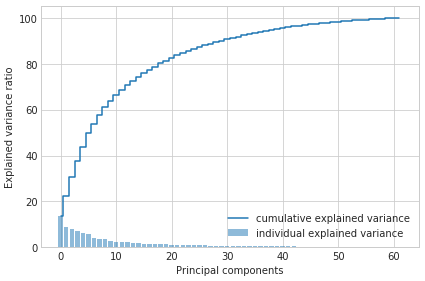

In [26]:
with plt.style.context('seaborn-whitegrid'):
    
    plt.figure(figsize=(6, 4))
    plt.bar(range(62), var_exp, alpha=.5, align='center', label='individual explained variance')
    plt.step(range(62), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [27]:
matrix_w = np.array(eig_pairs)[0:40, 1]
matrix_w = matrix_w.tolist()
matrix_w = np.reshape(matrix_w, (40, 62)).T
transformed = data.dot(matrix_w)

test_data = transformed[0:2500, :]
train_data = transformed[2500:, :]
test_data = np.asarray(test_data)
train_data = np.asarray(train_data)

In [28]:
all_data = []
for i in range(class_number):
    cl = train_data[np.where(train_labels == i), :]
    all_data.append(cl)

In [29]:
print("knn classifier")
class_density_estimation = distribution_estimation(test_data, train_data, train_labels, 10, class_number)
class_density_estimation = class_density_estimation.T 
classifier = BayesClassifier(class_density_estimation)
t_labels = classifier.classify(test_data)
cnf_matrix = confusion_matrix(test_labels, test_labels)
k_correct_rate = np.sum(np.diag(cnf_matrix))/test_labels.shape
print("k :", 10)
print("correct confusion rate : ", k_correct_rate)
print("probability of classification error : ", 1-k_correct_rate)
print("*****")


knn classifier
k : 10
correct confusion rate :  [1.]
probability of classification error :  [0.]
*****


In [30]:
print("parzen classifier") 
all_estimations = distribution_estimation_parzen(all, test_data, 1, class_number, parzen_window, hypercube_kernel)       
class_density_estimation = all_estimations.T  
classifier = BayesClassifier(class_density_estimation)
t_labels = classifier.classify(test_data)
cnf_matrix = confusion_matrix(test_labels, test_labels)
h_correct_rate = np.sum(np.diag(cnf_matrix))/test_labels.shape
print("h :", 1)
print("correct confusion rate : ", h_correct_rate)
print("probability of classification error : ", 1-h_correct_rate)
print("*****")

parzen classifier


TypeError: 'builtin_function_or_method' object is not subscriptable